<a id='top'></a>
# content
[split_line](#split_line)  
[split_line_into_segements](#split_line_into_segements)  
[interact_with_matplotlib_widget](#interact_with_matplotlib_widget)  
[generate_YOLO_training_data](#generate_YOLO_training_data)  
[YOLO_model_without_anchor_box](#YOLO_model_without_anchor_box)  
[training_YOLO_model](#training_YOLO_model)  

In [1]:
%matplotlib inline
# %matplotlib widget # 跟圖互動，可以用點選圖片中的某位置觸發程式
%env KERAS_BACKEND = tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import matplotlib as mpl
from random import shuffle
# from matplotlib.widgets import Cursor, Button
from ipywidgets import interact, IntSlider, Button
from ipywidgets import interact_manual
import IPython.display as ipd
# import networkx as nx # draw graph vertex & edge
# import pydub # audio
# from numpy.fft import fft, ifft, irfft, rfft # fourier transform
# import sympy as sym
# from sympy import S,N
# import locale # 資料處理 轉換數字格式

# from sklearn.linear_model import LinearRegression
# from keras.utils import np_utils #one hot encoding
# from keras.models import Sequential #神經網路的框架keras.models
from keras.layers import Dense, Activation, Embedding
from keras.layers import advanced_activations
# from keras.layers import LSTM
from keras.layers import Flatten # 將資料展平
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import Conv1D, MaxPool1D, MaxPooling1D
from keras.optimizers import SGD, Adadelta, Adam
from keras.models import model_from_json
# from keras.callbacks import History
# from keras.datasets import mnist # mnist內 包含手寫測試資料
# from keras.datasets import imdb # imdb內 包含電影評論資料
# from keras.preprocessing import sequence # 用來同整不同長度的電影評論，多的擷掉，少的補 0
# from keras.preprocessing.text import Tokenizer # 轉換文字成數字
# from sklearn.model_selection import train_test_split

# for Functional API
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers import Reshape
# for Functional API transfer learning
from keras.layers.core import Lambda
from keras import backend as K
from keras import metrics

# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

import matplotlib.image as mpimg # import image file
from PIL import Image, ImageEnhance, ImageFont, ImageDraw, ImageFilter # image processing

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


<a id='split_line'></a>
# split_line

Instructions for updating:
Colocations handled automatically by placer.


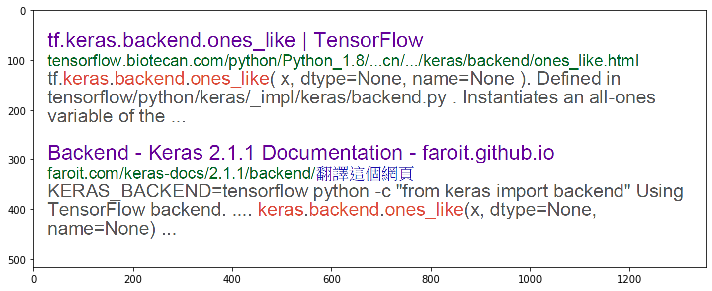

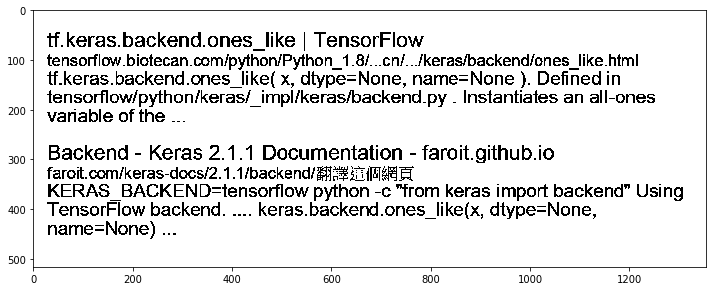

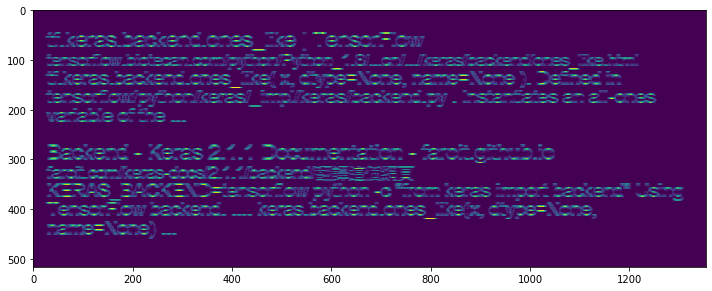

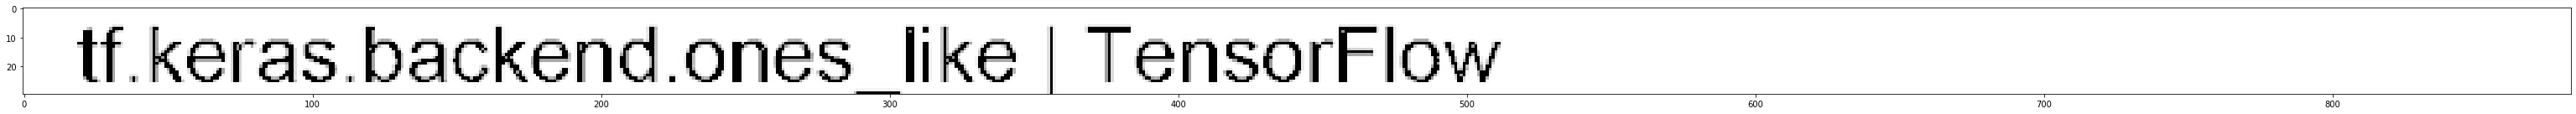

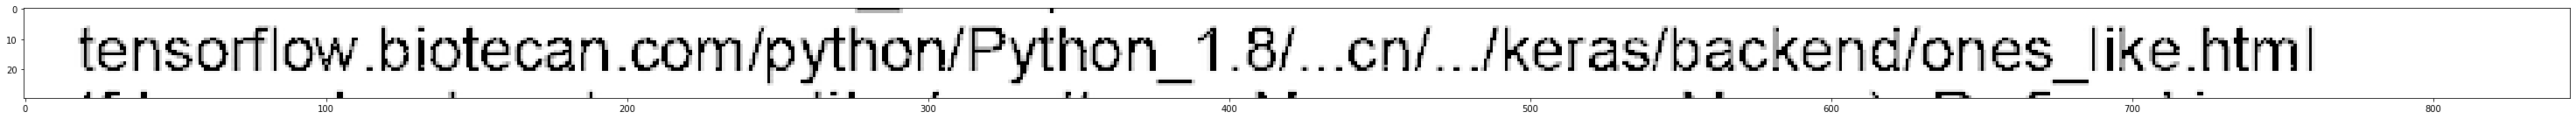

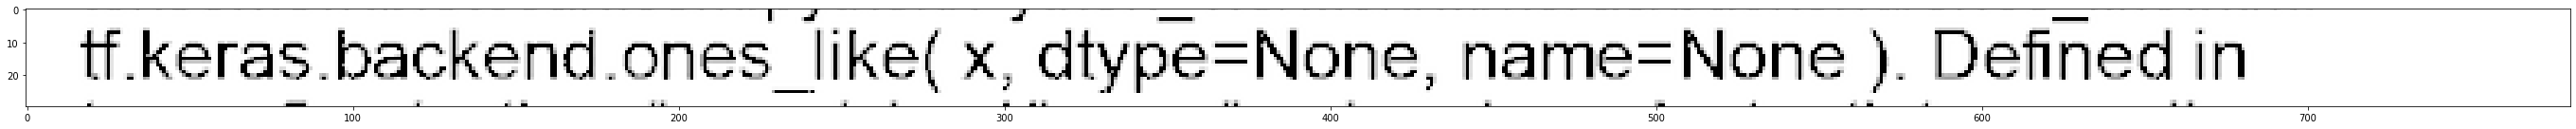

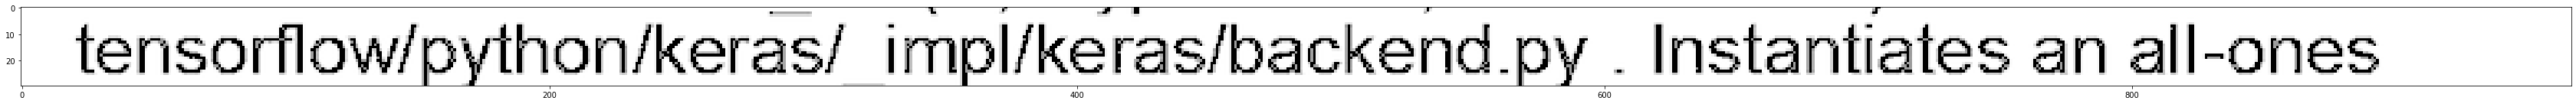

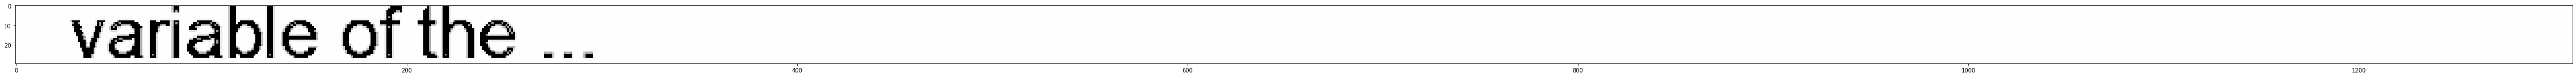

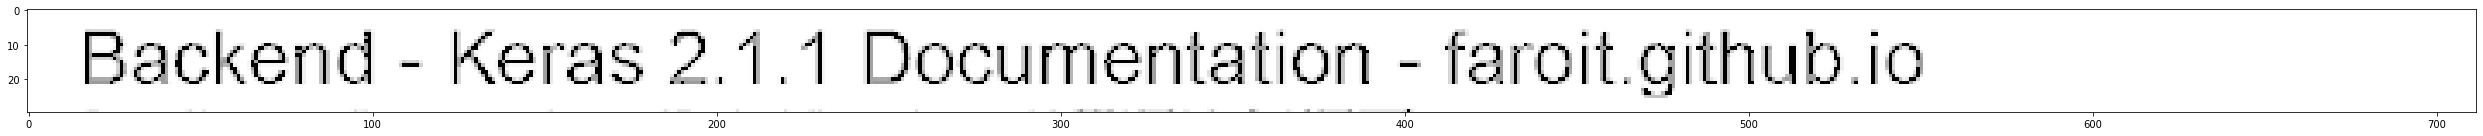

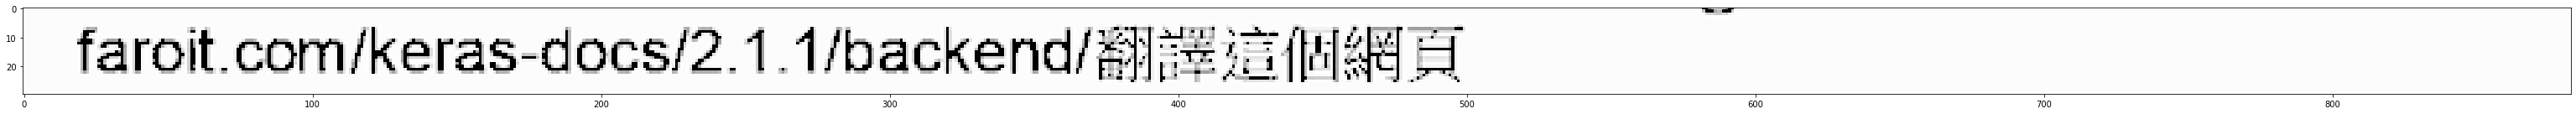

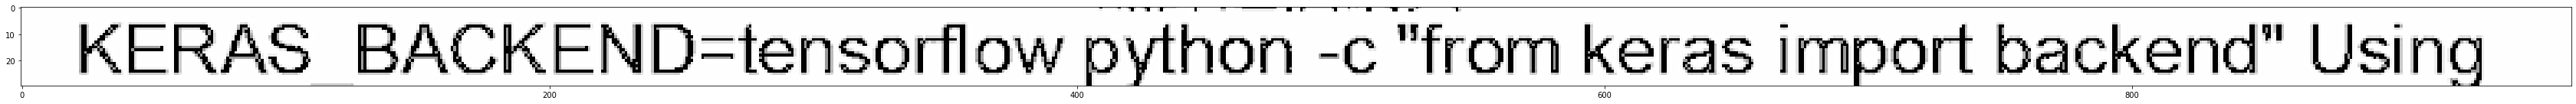

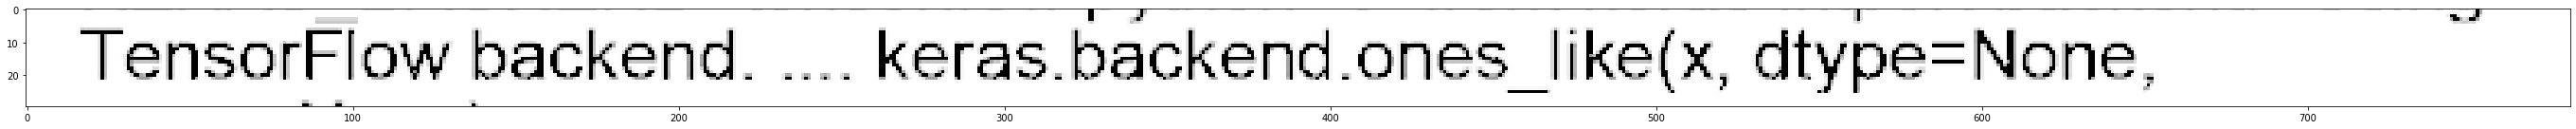

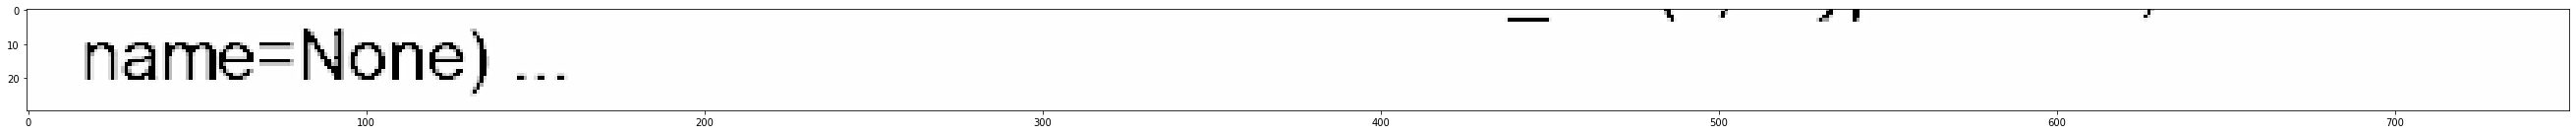

In [0]:
split_line_input = Input(shape = (None, None, 1), name = 'split_line_input')
# z = Lambda(lambda v: K.ones_like(v) - v, name = 'split_line_input_color_recerse')(split_line_input)
filter_size = 8
layer = Conv2D(3, (filter_size, filter_size), padding = 'same', trainable = False, name = 'split_line_c1')
z = layer(split_line_input)

### setting weights
w = layer.get_weights()
w[0][:, :, 0, 0] = 0
w[0][0, :, 0, 0] = filter_size
w[0][:, :, 0, 1] = 0
w[0][-1:, :, 0, 1] = filter_size
w[0][:, :, 0, 2] = 1
w[1] = np.zeros_like(w[1])
layer.set_weights(w)

split_line_Lambda = Lambda(lambda v: 
                           K.concatenate([v[:, :, :, 0:1] - v[:, :, :, 2:3], 
                                          v[:, :, :, 1:2] - v[:, :, :, 2:3]], 
                                         axis = -1), 
                           name = 'split_line_Lambda')(z)
z = Activation('relu', name = 'split_line_relu')(split_line_Lambda)
split_line_model = Model(split_line_input, z, name = 'split_line_model')
# print(split_line_model.summary())

def crop_array_image(img, *rects):
    y = img.shape[0]
    x = img.shape[1]
    startx, starty, cropx, cropy = rects
    endx = min(startx + cropx, x)
    endy = min(starty + cropy, y)
    return img[starty:endy, startx:endx]

def zooming_rectangle(*rects, h_rate = 1., w_rate = 1.):
    startx, starty, cropx, cropy = rects
    new_startx = int((1. - w_rate) * cropx / 2 + startx)
    new_starty = int((1. - h_rate) * cropy / 2 + starty)
    new_cropx = int(cropx * w_rate)
    new_cropy = int(cropy * h_rate)
    return (new_startx, new_starty, new_cropx, new_cropy)

def increase_contrast_function(x, s = 0.2, e = 0.8):
    max_x = np.max(x.reshape(-1))
    min_x = np.min(x.reshape(-1))
    assert max_x - min_x != 0, "In increase_contrast_function: There are no variations in the input data."
    if not (max_x <= 1. and min_x >= 0):
        x = (x - min_x) / (max_x - min_x)
    def normalized_increase_contrast_function(x):
        if x < s:
            return 0.
        if x > e:
            return 1.
        x -= s
        x *= e - s
        return -2 * x**3 + 3 * x**2
    x = np.vectorize(normalized_increase_contrast_function)(x)
    if not (max_x <= 1. and min_x >= 0):
        return x * (max_x - min_x) + min_x
    else:
        return x

image_index = 4
img_png_0 = mpimg.imread("image_test/line_test_{}.png".format(image_index))
height, width , _ = img_png_0.shape
assert height > filter_size * 2 and width > filter_size * 4, "The image is too small, please capture a large one!"
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_png_0, interpolation='nearest')
plt.tight_layout()

####### increase contrast #######
img_png = increase_contrast_function(img_png_0)
img_png = increase_contrast_function(img_png)
# img_png = np.average(img_png, axis = 2) # transform to only 1 chennel
img_png = np.min(img_png, axis = 2) # transform to only 1 chennel
img_png = 1 - img_png
# img_png = img_png[:, 450:500]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_png, interpolation='nearest', cmap='Greys')
plt.tight_layout()

predicts = split_line_model.predict(img_png.reshape(1, *(img_png.shape), 1))
A = np.zeros(predicts[0].shape[0:2])
A[0:-3, :] += predicts[0][3:, :, 0]
A[3:, :] += predicts[0][0:-3, :, 1]

# A = increase_contrast_function(A, s = 0.1, e = 0.99)
# A = increase_contrast_function(A, s = 0.01, e = 0.5)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(A, interpolation='nearest')
plt.tight_layout()

# B = np.average(A, axis = 1)
# B = np.max(A, axis = 1)
B = 0.5 * np.max(A, axis = 1) + 0.5 * np.average(A, axis = 1)
B = np.array([1. 
              if B[i] - np.min(B.reshape(-1)) > (np.max(B.reshape(-1)) - np.min(B.reshape(-1))) * 0.1 
              else 0. 
              for i in range(len(B))])
go_up_list = [0 for i in range(1) if B[0] > 0.5] + [i for i in range(len(B)-1) if B[i + 1] - B[i] > 0.5]
if B[-1] > 0.5:
    go_up_list.pop(-1)
go_down_list = [i for i in range(len(B)-1) if B[i] - B[i + 1] > 0.5]
assert len(go_up_list) == len(go_down_list), "The lenghts of go_up_list and go_down_list are not equal."
varlist = go_up_list + go_down_list
varlist.sort()

rectlist = [[0, varlist[2 * i], width, varlist[2 * i + 1] - varlist[2 * i]] 
            for i in range(len(varlist) // 2) 
           if varlist[2 * i + 1] - varlist[2 * i] >= filter_size]
for i in range(len(rectlist)):
    rectlist[i] = zooming_rectangle(*rectlist[i], h_rate = 1.5, w_rate = 1.)

line_list = []
line_list_normalize = []
line_list_normalize_ratio = [] # line_list_normalize_ratio[i] * line_list_normalize[i].shape[0] == line_list[i].shape[0]
new_line_hh = 30
assert len(rectlist) != 0, "There are no lines that is detected."
for rect in rectlist:
    C = crop_array_image(img_png, *rect)
    line_list.append(C)

    C_PIL = Image.fromarray(C)
    ww, hh = C_PIL.size
    new_line_ww = new_line_hh * ww // hh
    C_PIL = C_PIL.resize((new_line_ww, new_line_hh), Image.ANTIALIAS) # Not maintain the ratio
    # C.thumbnail((1000, 1000), Image.ANTIALIAS) # maintain the ratio
    C = np.array(C_PIL)
    C = increase_contrast_function(C, s = 0.1, e = 0.8)
    C -= np.min(C.reshape(-1))
    C = C / np.max(C.reshape(-1))
    line_list_normalize.append(C)
    line_list_normalize_ratio.append(hh / new_line_hh)
    # mpimg.imsave("image_test/line_test_line.png", C)

    fig, ax = plt.subplots(figsize=(100, 2))
    ax.imshow(C, interpolation='nearest', cmap='Greys')
    plt.tight_layout()

line_list_normalize_segements = []
segements_hh = new_line_hh
segements_ww = 120
assert segements_ww % 6 == 0, "YOLO model requires that segements_ww % 6 == 0"
segements_overlapping_ww = 20
for i in range(len(line_list_normalize)):
    line_list_normalize_segements.append([])
    new_line_ww = line_list_normalize[i].shape[1]
    number_of_segements = (new_line_ww - segements_overlapping_ww) // (segements_ww - segements_overlapping_ww)
    if (new_line_ww - segements_overlapping_ww) % (segements_ww - segements_overlapping_ww) != 0:
        number_of_segements += 1
    for j in range(number_of_segements):
        D = np.zeros((segements_hh, segements_ww))
        rect = [(segements_ww - segements_overlapping_ww) * j, 
                0, segements_ww, segements_hh]
        DD = crop_array_image(line_list_normalize[i], *rect)
        D[:, 0:DD.shape[1]] = DD
        line_list_normalize_segements[i].append(D)

<a id='split_line_into_segements'></a>
# split_line_into_segements

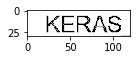

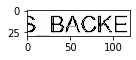

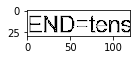

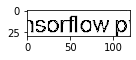

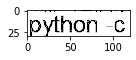

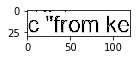

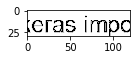

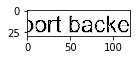

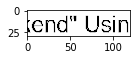

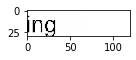

In [0]:
i = 7
for j in range(len(line_list_normalize_segements[i])):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(line_list_normalize_segements[i][j], interpolation='nearest', cmap='Greys')
    plt.tight_layout()

<a id='interact_with_matplotlib_widget'></a>
# interact_with_matplotlib_widget

In [0]:
# ################製作測試資料用##################

# # %matplotlib inline
# %matplotlib widget
# from matplotlib.widgets import Cursor, Button
# from IPython.display import clear_output

# i = 1
# j = 3
# C = line_list_normalize_segements[i][j]
# fig, ax = plt.subplots(figsize=(20, 1))
# ax.imshow(C, cmap='Greys')

# xs = []

# press_count = 0
# cilck_count = 0
# cursor = Cursor(ax,
#                 horizOn = False, # Controls the visibility of the horizontal line
#                 vertOn = True, # Controls the visibility of the vertical line
#                 color = 'green',
#                 linewidth = 2.0
#                )
# def onclick(event):
#     # clear_output()
#     global press_count, cilck_count
#     if press_count % 2 == 0:
#         global xs
#         x1, _1 = event.xdata, event.ydata
#         xs.append(x1)
#         if cilck_count % 4 < 2:
#             plt.vlines(x1, 0, C.shape[0], colors = "r")
#         else:
#             plt.vlines(x1, 0, C.shape[0], colors = "b")
#         cilck_count += 1

# def press(event):
#     # clear_output()
#     global press_count
#     if event.key == 'e':
#         press_count +=1
# fig.canvas.mpl_connect('button_press_event', onclick);
# fig.canvas.mpl_connect('key_press_event', press);
# # plt.tight_layout()
# # plt.show()

In [0]:
# np.array(xs).reshape((-1, 2))

array([[ 11.52124724,  27.13477856],
       [ 23.01088231,  38.32821123],
       [ 34.79344302,  44.21949158],
       [ 41.27385141,  54.23466818],
       [ 50.11077194,  66.01722889],
       [ 62.48246068,  79.5671737 ],
       [ 87.8149662 , 100.18665494],
       [104.31055119, 116.68223993]])

<a id='generate_YOLO_training_data'></a>
# generate_YOLO_training_data
### See [用-python-在圖像上寫字](https://medium.com/@sean22492249/%E7%94%A8-python-%E5%9C%A8%E5%9C%96%E5%83%8F%E4%B8%8A%E5%AF%AB%E5%AD%97-d62a431ea727)
### [How to get the font pixel height using PIL' ImageFont?](https://stackoverflow.com/questions/43060479/how-to-get-the-font-pixel-height-using-pil-imagefont)

In [0]:
segements_hh = 30
segements_ww = 120
grid_size = (1, segements_ww // 6)
labels = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", 
          "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", 
          "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", 
          "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", 
          "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", 
          " ", "(", ")", ",", ".", "[", "]", "'", "\""]

def GaussianBlur():
    GaussianBlur_input = Input(shape = (None, None, 1), name = 'GaussianBlur_input')
    filter_size = 4
    layer = Conv2D(1, (filter_size, filter_size), padding = 'same', trainable = False, name = 'GaussianBlur_c1')
    GaussianBlur_output = layer(GaussianBlur_input)

    ### setting weights
    w = layer.get_weights()
    kernel = np.array([1., 2., 2., 1.]).reshape(1, -1)
    kernel = (kernel.T).dot(kernel)
    kernel = kernel / np.sum(kernel.reshape(-1))
    w[0][:, :, 0, 0] = kernel
    w[1] = np.zeros_like(w[1])
    layer.set_weights(w)

    # GaussianBlur_model
    return Model(GaussianBlur_input, GaussianBlur_output, name = 'GaussianBlur_model')

def generate_YOLO_a_single_training_data(labels, 
                                         imshow = False,
                                         draw_boxes = False, 
                                         boxes_shifting_error = -1, 
                                         ttf = 'times.ttf', 
                                         font_size = 28, 
                                         left = 0, top = 0, 
                                         segements_hh = 30, segements_ww = 120):
    grid_ww = segements_ww // grid_size[1]
    left -= np.random.randint(grid_ww)
    total_classes_number = len(labels)
    frame = Image.fromarray(np.zeros((segements_hh, segements_ww)))
    # frame = frame.convert("RGB")
    # frame = frame.convert("L")
    draw = ImageDraw.Draw(frame)
    # font_size = 28
    font = ImageFont.truetype(ttf, font_size) # fonts/calibri.ttf fonts/calibrili.ttf
    # impact.ttf 的 getsize 會跑掉，而且字體太特殊

    string_len = 20 if np.random.binomial(1, 0.9) > 0.5 else 7
    string_len = string_len if np.random.binomial(1, 0.9) > 0.5 else 0
    string = ''.join([labels[i] for i in np.random.randint(total_classes_number, size = string_len)])
    draw.text((left, top), string, 1., font = font)

    ######### setting bounding boxes #########
    bounding_boxes = []
    for idx in range(string_len):
        size = np.array([font.font.getsize(string[0:idx]), 
                         font.font.getsize(string[0:idx + 1])])[:, 0, 0] + boxes_shifting_error
        cw = float(size[0] + size[1]) / 2. + left
        ww = float(size[1] - size[0])
        label_vector = np.zeros(total_classes_number)
        label_vector[labels.index(string[idx])] += 1.
        box = np.zeros(1 + 2 + total_classes_number)
        box[0] = 1.
        box[1] = cw
        box[2] = ww
        box[3:] = label_vector
        if left + size[0] > (-1 * ww * 0.1) and left + size[1] < segements_ww:
            bounding_boxes.append(box)

    single_y_train = np.zeros((grid_size[0], grid_size[1], 1 + 2 + total_classes_number))
    for box in bounding_boxes:
        box = box.copy()
        i = int(box[1] // grid_ww)
        box[1] = float(box[1] % grid_ww) / float(grid_ww)
        box[2] = float(box[2]) / float(grid_ww)
        single_y_train[0, i, :] = box

    ######### show #########
    if imshow and draw_boxes:
        for box in bounding_boxes:
            draw.rectangle((box[1] - box[2] / 2, 0, box[1] + box[2] / 2 , 30 - 1), outline = 0.1 + np.random.rand() / 2.)

    single_x_train = np.array(frame)
    if np.random.binomial(1, 0.8) > 0.5 and not (imshow and draw_boxes):
        single_x_train = GaussianBlur().predict(single_x_train.reshape(1, *(single_x_train.shape), 1))[0, :, :, 0]
    if imshow:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(single_x_train, interpolation='nearest', cmap='Greys')
        plt.tight_layout()

    return single_x_train.reshape(segements_hh, segements_ww, 1), single_y_train

# _, _ = generate_YOLO_a_single_training_data(labels, 
#                                          imshow = True,
#                                          draw_boxes = True, 
#                                          boxes_shifting_error = -1, 
#                                          ttf = 'times.ttf', 
#                                          font_size = 28, 
#                                          left = -5, top = 0, 
#                                          segements_hh = 30, segements_ww = 120)

def data_generator(train_len = 100, test_len = 10):

    # train_len = 100
    # test_len = 10

    x_train_list = []
    y_train_list = []
    for i in range(train_len):
        single_x_train, single_y_train = generate_YOLO_a_single_training_data(labels, 
    #                                          imshow = True,
    #                                          draw_boxes = True, 
                                             boxes_shifting_error = -1, 
                                             ttf = 'times.ttf', 
                                             font_size = 28, 
                                             left = -5, top = 0, 
                                             segements_hh = 30, segements_ww = 120)
        x_train_list.append(single_x_train)
        y_train_list.append(single_y_train)
    x_train_0 = np.array(x_train_list)
    y_train_0 = np.array(y_train_list)

    x_test_list = []
    y_test_list = []
    for i in range(test_len):
        single_x_test, single_y_test = generate_YOLO_a_single_training_data(labels, 
    #                                          imshow = True,
    #                                          draw_boxes = True, 
                                             boxes_shifting_error = -1, 
                                             ttf = 'times.ttf', 
                                             font_size = 28, 
                                             left = -5, top = 0, 
                                             segements_hh = 30, segements_ww = 120)
        x_test_list.append(single_x_test)
        y_test_list.append(single_y_test)
    x_test_0 = np.array(x_test_list)
    y_test_0 = np.array(y_test_list)
    return x_train_0, y_train_0, x_test_0, y_test_0

In [0]:
for i in range(5):
    x_train_0, y_train_0, x_test_0, y_test_0 = data_generator(train_len = 100, test_len = 10)

    if not 'x_train' in vars():
        try:
            train = np.load('numpy_array/training_data.npz')
            test = np.load('numpy_array/testing_data.npz')
            x_train = train['x_train']
            y_train = train['y_train']
            x_test = test['x_test']
            y_test = test['y_test']
        except:
            x_train = x_train_0
            y_train = y_train_0
            x_test = x_test_0
            y_test = y_test_0
            np.savez('numpy_array/training_data.npz', x_train = x_train, y_train = y_train)
            np.savez('numpy_array/testing_data.npz', x_test = x_test, y_test = y_test)
            print(len(x_train), len(y_train), len(x_test), len(y_test))
            continue

    x_train = np.concatenate((x_train, x_train_0), axis=0)
    y_train = np.concatenate((y_train, y_train_0), axis=0)
    x_test = np.concatenate((x_test, x_test_0), axis=0)
    y_test = np.concatenate((y_test, y_test_0), axis=0)

    print(len(x_train), len(y_train), len(x_test), len(y_test))

np.savez('numpy_array/training_data.npz', x_train = x_train, y_train = y_train)
np.savez('numpy_array/testing_data.npz', x_test = x_test, y_test = y_test)

# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(x_train[-1].reshape(segements_hh, segements_ww), interpolation='nearest', cmap='Greys')
# plt.tight_layout()

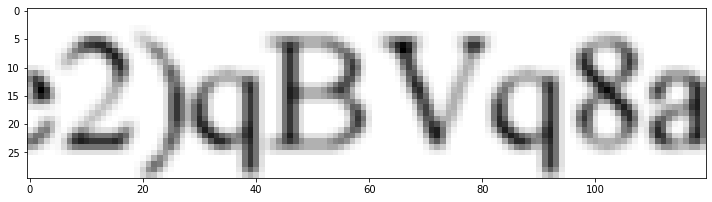

In [2]:
segements_hh = 30
segements_ww = 120

train = np.load('numpy_array/training_data.npz')
test = np.load('numpy_array/testing_data.npz')
x_train = train['x_train']
y_train = train['y_train']
x_test = test['x_test']
y_test = test['y_test']

# x_train = np.concatenate((x_train, x_train_0), axis=0)
# y_train = np.concatenate((y_train, y_train_0), axis=0)
# x_test = np.concatenate((x_test, x_test_0), axis=0)
# y_test = np.concatenate((y_test, y_test_0), axis=0)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(x_train[-1].reshape(segements_hh, segements_ww), interpolation='nearest', cmap='Greys')
plt.tight_layout()

In [0]:
# np.savez('numpy_array/training_data.npz', x_train = x_train, y_train = y_train)
# np.savez('numpy_array/testing_data.npz', x_test = x_test, y_test = y_test)

<a id='YOLO_model_without_anchor_box'></a>
# YOLO_model_without_anchor_box
<pre>
<b>output_dim:</b> (1 , (segements_ww // 6) , (1 + 2 + total_classes_number))

    <b>1 , (segements_ww // 6):</b> grid_size = (1, segements_ww // 6)
        slice (segements_ww) into (segements_ww // 6) parts,  
        and slice segements_hh into 1 parts.

    <b>(1 + 2 + total_classes_number):</b>  
        <b>1:</b> pc  
        <b>2:</b> the width informations of bounding box (default height coordinates: 0, segements_hh)  
            (relative_coordinate_of_centor_of_box, relative_width_of_box)  
        <b>total_classes_number:</b> = len(labels), one hot encoding
</pre>

In [3]:
segements_hh = 30
segements_ww = 120
grid_size = (1, segements_ww // 6)

labels = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", 
          "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", 
          "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", 
          "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", 
          "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", 
          " ", "(", ")", ",", ".", "[", "]", "'", "\""]
total_classes_number = len(labels)

def IOU(grid_idx1, p1, grid_idx2, p2): # only for width
    c1, w1 = p1
    c2, w2 = p2
    grid_idx1 = float(grid_idx1)
    grid_idx2 = float(grid_idx2)
    e1 = grid_idx1 + c1 + (w1 / 2)
    s1 = grid_idx1 + c1 - (w1 / 2)
    e2 = grid_idx2 + c2 + (w2 / 2)
    s2 = grid_idx2 + c2 - (w2 / 2)
    intersection = max(0., min(e1, e2) - max(s1, s2))
    union = max(e1, e2) - min(s1, s2)
    return intersection / union if round(union, 8) != 0. else 1.

# non_maximum_suppression returns a list of 
# "[grid_index_hh, grid_index_ww, single_grid_YOLO_output] s"
def non_maximum_suppression(single_YOLO_output, threshold = 0.5, IOU_threshold = 0.5):
    YOLO_available_list = []
    temp = []
    for i in range(single_YOLO_output.shape[0]):
        for j in range(single_YOLO_output.shape[1]):
            if single_YOLO_output[i, j, 0] >= threshold:
                temp.append([i, j, single_YOLO_output[i, j, :]])
    def sortby(ele):
        return ele[2][0]
    while len(temp) > 0:
        temp.sort(key = sortby)
        available = temp.pop(-1)
        YOLO_available_list.append(available)
        poping_list = []
        for i in range(len(temp)):
            if IOU(available[1], available[2][1:3], temp[i][1], temp[i][2][1:3]) > IOU_threshold:
                poping_list.append(temp[i])
        for poping_obj in poping_list:
            temp.pop(temp.index(poping_obj))
    return YOLO_available_list

# translate_boxes_format_from_YOLO returns a list of 
# "[rect_already_to_crop_in_original_image, the_probability_in_class, class_index] s"
def translate_boxes_format_from_YOLO(YOLO_boxes_list, 
                                   line_start_coordinate, segement_index, grid_size, line_normalize_ratio = 1., 
                                     segements_hh = 30, segements_ww = 120, segements_overlapping_ww = 20):
    segements_co_overlapping_ww = float(segements_ww - segements_overlapping_ww)
    segements_hh = float(segements_hh)
    segements_ww = float(segements_ww)
    line_start_coordinate = float(line_start_coordinate)
    segement_index = float(segement_index)
    segement_normalize_ratio_hh = segements_hh * line_normalize_ratio
    segement_normalize_ratio_ww = segements_ww * line_normalize_ratio
    segement_start_coordinate_ww = segements_co_overlapping_ww * segement_index * line_normalize_ratio
    return [[[int(line_start_coordinate), 
              int(segement_start_coordinate_ww + 
              (float(YOLO_box[1]) + YOLO_box[2][1] - (YOLO_box[2][2] / 2)) * segement_normalize_ratio_ww / grid_size[1]), 
              int(segement_normalize_ratio_hh) + 1, 
             int(YOLO_box[2][2] * (segements_ww / grid_size[1]) * line_normalize_ratio) + 1], 
             np.max(YOLO_box[2][3:]), 
             np.argmax(YOLO_box[2][3:])] 
            for YOLO_box in YOLO_boxes_list]

def plot_boundind_boxes_with_labels(img, labels, *format_translated_boxes, fontsize = 9, figsize = (10, 10)):
    fig,ax = plt.subplots(figsize = figsize)
    ax.imshow(img)

    for format_translated_box in format_translated_boxes:
        rect, the_probability_in_class, class_index = format_translated_box
        y1, x1, CC, LL = rect
        text = "{} {}".format(labels[class_index], "{:.2f}".format(the_probability_in_class))

        colors = plt.cm.hsv(np.linspace(0, 1, total_classes_number)).tolist()
        color = colors[class_index]
        # color = np.random.rand(4)
        # color[3] = (color[3]+3)/4
        rect = patches.Rectangle((x1, y1), LL, CC, linewidth = 1, edgecolor = color, facecolor = 'none')
        ax.add_patch(rect)
        ax.text(x1, y1, text, fontsize = fontsize, 
                horizontalalignment='left',
                verticalalignment='baseline',
                # transform=ax.transAxes, 
               bbox={'facecolor': color[0:3], 'alpha': color[3], 'edgecolor': 'none'})

############################################# YOLO model #############################################
layer_id = 0
YOLO_input = Input(shape = (segements_hh, segements_ww, 1), name = 'YOLO_input')
z = YOLO_input

######### main_body #########
layer_id += 1
z = Conv2D(16, 8, padding = 'same', name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)

layer_id += 1
z = Conv2D(32, 8, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
layer_id += 1
z_resnet = z
z = Conv2D(32, 8, padding = 'same', name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
z = add([z, z_resnet], name = 'YOLO_add{}'.format(layer_id))

layer_id += 1
z = Conv2D(64, 5, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
layer_id += 1
z_resnet = z
z = Conv2D(64, 5, padding = 'same', name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
z = add([z, z_resnet], name = 'YOLO_add{}'.format(layer_id))

layer_id += 1
z = Conv2D(128, 3, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
layer_id += 1
z_resnet = z
z = Conv2D(128, 3, padding = 'same', name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
z = add([z, z_resnet], name = 'YOLO_add{}'.format(layer_id))
main_body = z

######### pc #########
pc_layer_start = layer_id + 1
z = main_body
# layer_id += 1
# z = Conv2D(64, 3, name = 'YOLO_c{}'.format(layer_id))(z)
# z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
# z = MaxPool2D(pool_size = (2, 2), name = 'YOLO_p{}'.format(layer_id))(z)
layer_id += 1
z = Conv2D(128, 3, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
layer = MaxPool2D(pool_size = (2, 2), name = 'YOLO_p{}'.format(layer_id))
z = layer(z)

layer_id += 1
assert layer.output_shape[-2] >= grid_size[1], "YOLO input shape is too small."
filter_size = [layer.output_shape[-3] - grid_size[0] + 1, layer.output_shape[-2] - grid_size[1] + 1]
z = Conv2D(1, filter_size, name = 'YOLO_c{}'.format(layer_id), activation = 'sigmoid')(z)
pc_output = z
pc_layer_end = layer_id

######### boxes_position_informations #########
boxes_position_informations_layer_start = layer_id + 1
z = main_body
# layer_id += 1
# z = Conv2D(64, 3, name = 'YOLO_c{}'.format(layer_id))(z)
# z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
# z = MaxPool2D(pool_size = (2, 2), name = 'YOLO_p{}'.format(layer_id))(z)
layer_id += 1
z = Conv2D(128, 3, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
layer = MaxPool2D(pool_size = (2, 2), name = 'YOLO_p{}'.format(layer_id))
z = layer(z)

layer_id += 1
assert layer.output_shape[-2] >= grid_size[1], "YOLO input shape is too small."
filter_size = [layer.output_shape[-3] - grid_size[0] + 1, layer.output_shape[-2] - grid_size[1] + 1]
z = Conv2D(2, filter_size, name = 'YOLO_c{}'.format(layer_id))(z)
layer_id += 1
z = Lambda(lambda v: K.concatenate([K.sigmoid(v[:, :, :, 0:1]), K.exp(v[:, :, :, 1:])], axis = 3), 
           name = 'YOLO_L{}'.format(layer_id))(z)
boxes_position_informations_output = z
boxes_position_informations_layer_end = layer_id

######### classes_classification #########
classes_classification_layer_start = layer_id + 1
z = main_body
# layer_id += 1
# z = Conv2D(64, 3, name = 'YOLO_c{}'.format(layer_id))(z)
# z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
# z = MaxPool2D(pool_size = (2, 2), name = 'YOLO_p{}'.format(layer_id))(z)
layer_id += 1
z = Conv2D(128, 3, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
layer = MaxPool2D(pool_size = (2, 2), name = 'YOLO_p{}'.format(layer_id))
z = layer(z)

layer_id += 1
assert layer.output_shape[-2] >= grid_size[1], "YOLO input shape is too small."
filter_size = [layer.output_shape[-3] - grid_size[0] + 1, layer.output_shape[-2] - grid_size[1] + 1]
z = Conv2D(total_classes_number, filter_size, name = 'YOLO_c{}'.format(layer_id), activation = 'relu')(z)
layer_id += 1
z = Conv2D(total_classes_number, 1, name = 'YOLO_c{}'.format(layer_id), activation = 'softmax')(z)
classes_classification_output = z
classes_classification_layer_end = layer_id

######### concatenate & YOLO_output #########
layer_id += 1
z = concatenate([pc_output, boxes_position_informations_output, classes_classification_output], 
                axis = 3, name = 'YOLO_concatenate{}'.format(layer_id))
YOLO_output = z
YOLO_model = Model(YOLO_input, YOLO_output, name = 'YOLO_model')
print('pc_layer: \t\t\t\t{: >2} ~ {: >2}'.format(pc_layer_start, 
                                    pc_layer_end))
print('boxes_position_informations_layer: \t{: >2} ~ {: >2}'.format(boxes_position_informations_layer_start, 
                                    boxes_position_informations_layer_end))
print('classes_classification_layer: \t\t{: >2} ~ {: >2}'.format(classes_classification_layer_start, 
                                    classes_classification_layer_end))
print(YOLO_model.summary())

Instructions for updating:
Colocations handled automatically by placer.
pc_layer: 				 8 ~  9
boxes_position_informations_layer: 	10 ~ 12
classes_classification_layer: 		13 ~ 15
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
YOLO_input (InputLayer)         (None, 30, 120, 1)   0                                            
__________________________________________________________________________________________________
YOLO_c1 (Conv2D)                (None, 30, 120, 16)  1040        YOLO_input[0][0]                 
__________________________________________________________________________________________________
YOLO_LeakyReLU_1 (LeakyReLU)    (None, 30, 120, 16)  0           YOLO_c1[0][0]                    
__________________________________________________________________________________________________
YOLO_c2 (Conv2D)              

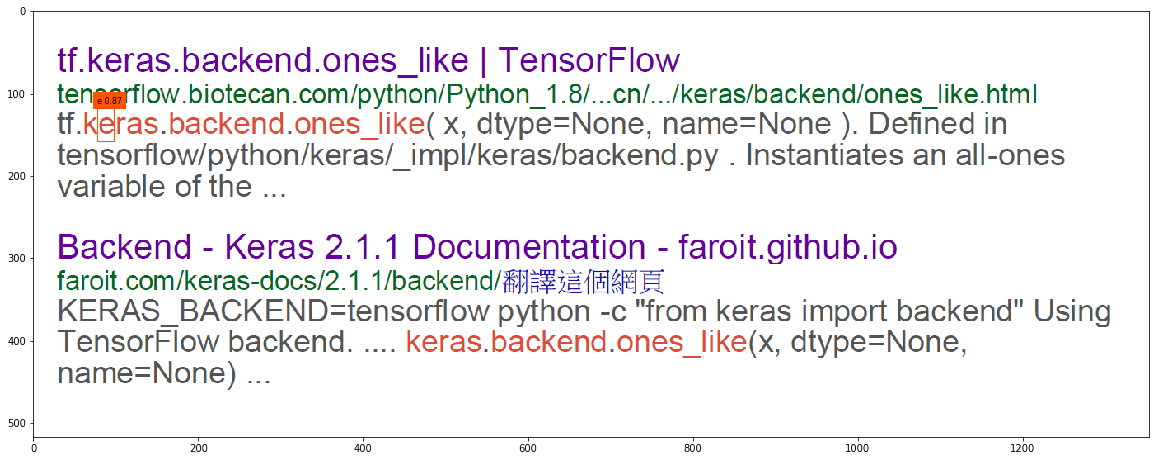

In [0]:
#################################################################################################################
################################# testing whether the functions work ############################################
#################################################################################################################

# [grid_index_hh, grid_index_ww, single_grid_YOLO_output] output of non_maximum_suppression
# [rect_already_to_crop_in_original_image, the_probability_in_class, class_index] output of translate_boxes_format_from_YOLO
grid_index_hh = 0
grid_index_ww = 9
single_grid_YOLO_output = np.zeros(1 + 2 + total_classes_number)
single_grid_YOLO_output[0] = 0.66
single_grid_YOLO_output[1] = 0.8
single_grid_YOLO_output[2] = 2.3
single_grid_YOLO_output[3 + 4] = 0.87
YOLO_boxes_list = [[grid_index_hh, grid_index_ww, single_grid_YOLO_output]]
rect_already_to_crop_in_original_image, the_probability_in_class, class_index = translate_boxes_format_from_YOLO(
    YOLO_boxes_list, 
    line_start_coordinate = 112, segement_index = 0, grid_size = (1, 120 // 6), line_normalize_ratio = 1.5, 
    segements_hh = 30, segements_ww = 120, segements_overlapping_ww = 20)[0]
plot_boundind_boxes_with_labels(mpimg.imread("image_test/line_test_4.png"), labels, 
                                *[[rect_already_to_crop_in_original_image, the_probability_in_class, class_index]], 
                                fontsize = 8, figsize = (20, 20))

<a id='training_YOLO_model'></a>
# training_YOLO_model

In [4]:
def YOLO_loss(y_true, y_pred):
    def IOU_in_loss(p1, p2): # only for width
        c1 = p1[:, :, 0:1]
        w1 = p1[:, :, 1:]
        c2 = p2[:, :, 0:1]
        w2 = p2[:, :, 1:]
        e1 = c1 + (w1 / 2)
        s1 = c1 - (w1 / 2)
        e2 = c2 + (w2 / 2)
        s2 = c2 - (w2 / 2)
        min_e = K.min(K.concatenate([e1, e2], axis = 2), axis = 2)
        max_e = K.max(K.concatenate([e1, e2], axis = 2), axis = 2)
        min_s = K.min(K.concatenate([s1, s2], axis = 2), axis = 2)
        max_s = K.max(K.concatenate([s1, s2], axis = 2), axis = 2)
        intersection = K.relu(min_e - max_s)
        union = max_e - min_s
        return intersection / union
    
    loss_pc = K.sum(metrics.binary_crossentropy(y_true[:, 0, :, 0:1], y_pred[:, 0, :, 0:1]) * (y_true[:, 0, :, 0] * 10 + K.ones_like(y_true[:, 0, :, 0])), 
                    axis = 1)
    loss_IOU = K.sum((K.ones_like(y_true[:, 0, :, 0]) - IOU_in_loss(y_true[:, 0, :, 1:3], y_pred[:, 0, :, 1:3]))
                     * y_true[:, 0, :, 0], 
                     axis = 1)
    loss_classes = K.sum(metrics.categorical_crossentropy(y_true[:, 0, :, 3:], y_pred[:, 0, :, 3:])
                         * y_true[:, 0, :, 0], 
                         axis = 1)
    return loss_pc + loss_IOU + loss_classes
    return loss_pc
YOLO_model.compile(loss = YOLO_loss, optimizer = Adam(), metrics = ['accuracy'])

In [5]:
# # YOLO_model = model_from_json(open('json_h5/OCR_YOLO_model.json').read())
# YOLO_model.load_weights('json_h5/OCR_YOLO_model.h5')
# YOLO_model.compile(loss = YOLO_loss, optimizer = Adam(), metrics = ['accuracy'])

In [60]:
YOLO_model.fit(x_train, y_train, batch_size = 32, epochs = 10, shuffle = True);

Epoch 1/10
11000/11000 [==============================] - 35s 3ms/step - loss: 27.9433 - acc: 0.3134
Epoch 2/10
11000/11000 [==============================] - 34s 3ms/step - loss: 27.3175 - acc: 0.3133
Epoch 3/10
11000/11000 [==============================] - 34s 3ms/step - loss: 26.8550 - acc: 0.3135
Epoch 4/10
11000/11000 [==============================] - 35s 3ms/step - loss: 26.3736 - acc: 0.3134
Epoch 5/10
11000/11000 [==============================] - 34s 3ms/step - loss: 25.6851 - acc: 0.3133
Epoch 6/10
11000/11000 [==============================] - 34s 3ms/step - loss: 25.1871 - acc: 0.3134
Epoch 7/10
11000/11000 [==============================] - 35s 3ms/step - loss: 24.7677 - acc: 0.3133
Epoch 8/10
11000/11000 [==============================] - 34s 3ms/step - loss: 24.4263 - acc: 0.3134
Epoch 9/10
11000/11000 [==============================] - 34s 3ms/step - loss: 24.0128 - acc: 0.3132
Epoch 10/10
11000/11000 [==============================] - 34s 3ms/step - loss: 23.4377 - a

In [6]:
# score = YOLO_model.evaluate(x_test, y_test, batch_size = len(x_test))
# print("Loss: {: >4f}.\t準確率: {: >2f}".format(score[0], score[1] * 100))
predict = YOLO_model.predict(x_test)

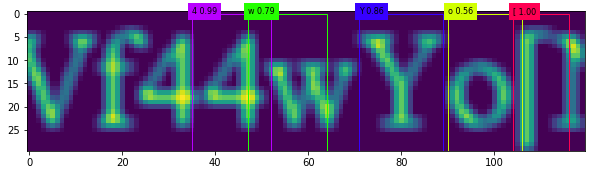

In [7]:
segements_hh = 30
segements_ww = 120
segements_overlapping_ww = 20

# predict = YOLO_model.predict(x_train)
plot_box_img = x_test # x_train # x_test
plot_box_array = predict # y_train # predict # y_test
# plot_box_img = x_train # x_train # x_test
# plot_box_array = predict
# plot_box_array = y_train

idx = 16
# YOLO_boxes_list = [[grid_index_hh, grid_index_ww, single_grid_YOLO_output]]
# YOLO_boxes_list = [[0, i, plot_box_array[idx][0, i ,:]] 
#                    for i in range(grid_size[1]) if plot_box_array[idx][0, i ,0] > 0.5]
# YOLO_boxes_list = non_maximum_suppression(single_YOLO_output, threshold = 0.5, IOU_threshold = 0.5)
YOLO_boxes_list = non_maximum_suppression(plot_box_array[idx], threshold = 0.9, IOU_threshold = 0.3)

translate_boxes_list = translate_boxes_format_from_YOLO(
    YOLO_boxes_list, 
    line_start_coordinate = 0, segement_index = 0, grid_size = grid_size, line_normalize_ratio = 1., 
    segements_hh = segements_hh, segements_ww = segements_ww, segements_overlapping_ww = segements_overlapping_ww)
# translate_boxes_list = list of "[rect_already_to_crop_in_original_image, the_probability_in_class, class_index] s"
plot_boundind_boxes_with_labels(plot_box_img[idx].reshape(segements_hh, segements_ww), labels, 
                                *translate_boxes_list, 
                                fontsize = 8, figsize = (10, 10))

In [ ]:
# open('json_h5/OCR_YOLO_model.json','w').write(YOLO_model.to_json())
YOLO_model.save_weights('json_h5/OCR_YOLO_model.h5')